# Load ds005514 and start training

In [55]:
from eegdash import EEGDash
from eegdash.data_utils import RawEEGDash

eegdashdata = EEGDash(is_public=False)
records = eegdashdata.find({'dataset': 'ds005514', 'task': 'RestingState'})
records = records[0:10]

print("number of records: ", len(records))
print("first record: ", records[0]) # current call




number of records:  10
first record:  {'_id': ObjectId('6789a3c766ea5ef303140d0c'), 'schema_ref': 'eeg_signal', 'data_name': 'ds005514_sub-NDARRW481GFE_task-RestingState_eeg.set', 'dataset': 'ds005514', 'bidspath': 'ds005514/sub-NDARRW481GFE/eeg/sub-NDARRW481GFE_task-RestingState_eeg.set', 'subject': 'NDARRW481GFE', 'task': 'RestingState', 'session': '', 'run': '', 'sampling_frequency': 500, 'modality': 'EEG', 'has_file': True, 'version_timestamp': 0, 'time_of_save': 1739409119098056, 'time_of_removal': None, 'channel_names': ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61', 'E62', 'E63', 'E64', 'E65', 'E66', 'E67', 'E68', 

In [56]:
from braindecode.datasets import BaseDataset, BaseConcatDataset
gender_to_label = {'M': int(0), 'F': int(1)}

allEEGDash = []
records[0]
for record in records:
    s3_path = eegdashdata.get_s3path(record)
    sfreq = record['sampling_frequency']
    nchans = record['nchans']
    ntimes = record['ntimes']
    ch_names = record['channel_names']
    ch_types = record['channel_types']
    s3_path = eegdashdata.get_s3path(record)
    eegdash = BaseDataset(RawEEGDash(s3_path, {'sfreq': sfreq, 'nchans': nchans, 'n_times': ntimes, 'ch_types': ch_types, 'ch_names': ch_names}, preload=False), target_name='genderbin')
    eegdash.set_description({'age': record['participantinfo']['age'], 'gender': record['participantinfo']['gender'], 'genderbin': gender_to_label[record['participantinfo']['gender']], 'subject': record['subject']})
    allEEGDash.append(eegdash)


/Users/arno/Python/EEG-Dash-Data/.venv/lib/python3.11/site-packages/braindecode/datasets/base.py:131: UserWarning: 'genderbin' not in description. '__getitem__'will fail unless an appropriate target is added to description.
  warnings.warn(f"'{name}' not in description. '__getitem__'"


In [57]:
eegdash_braindecode = BaseConcatDataset(allEEGDash)

In [58]:
import numpy as np

res = eegdash_braindecode.description
res

age gender  genderbin       subject
0   5.7012      M          0  NDARRW481GFE
1  13.5951      M          0  NDARTE553VC1
2  12.0696      F          1  NDARFJ488VPT
3  10.7882      F          1  NDARHT403JJJ
4  12.5762      M          0  NDARYW170CAA
5  10.0025      F          1  NDARYE017HZA
6   6.1071      M          0  NDARXX426ELJ
7   7.2295      M          0  NDARUZ818ADU
8   6.1426      M          0  NDARZZ741VJE
9   9.9038      M          0  NDARAW216PM7

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
sampling_freq: 500.0
(array([[ 2402.36499023,  2358.11035156,  2292.43237305, ...,
        -3395.13867188, -3489.63623047, -3587.44360352]]), array([ 10.   ,  10.002,  10.004, ..., 445.466, 445.468, 445.47 ]))
-3617.61279296875 4021.9267578125


/Users/arno/Python/EEG-Dash-Data/.venv/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


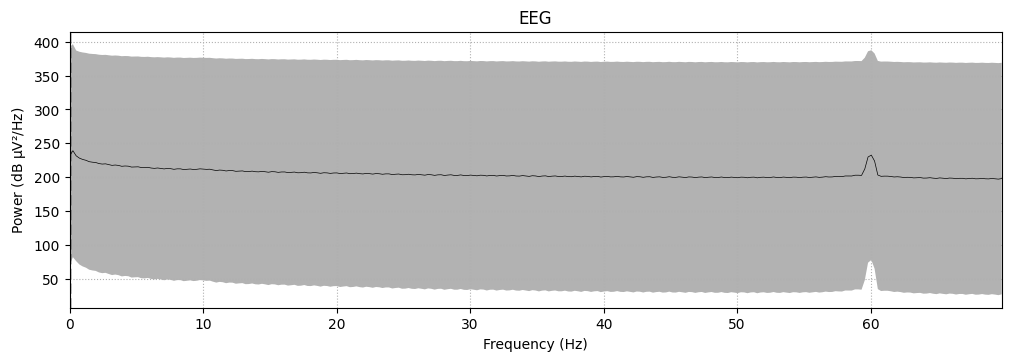

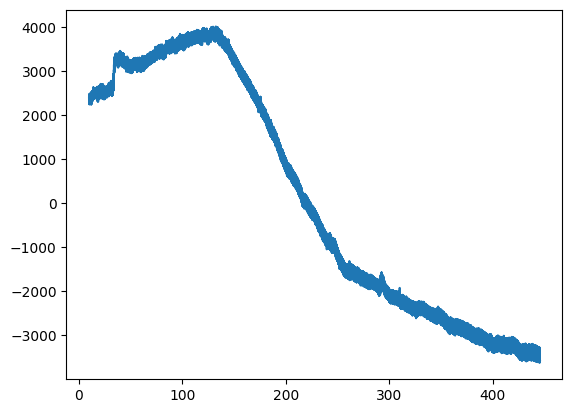

In [59]:
import matplotlib.pyplot as plt
import numpy as np
raw = eegdash_braindecode.datasets[1].raw
fig = raw.compute_psd(fmax=70).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
sampling_freq = raw.info["sfreq"]
print('sampling_freq:', sampling_freq)
start_stop_seconds = np.array([10, 500])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
print(np.min(y),np.max(y))
plt.figure()
plt.plot(x, y)
plt.show()

In [61]:
from braindecode.preprocessing import (preprocess, Preprocessor, create_fixed_length_windows)

preprocessors = [   
    Preprocessor("filter", l_freq=1, h_freq=55),
    Preprocessor("resample", sfreq=125)
]

preprocess(eegdash_braindecode, preprocessors, n_jobs=-1)

windows_ds = create_fixed_length_windows(eegdash_braindecode, start_offset_samples=0, stop_offset_samples=None,
        window_size_samples=614,
        window_stride_samples=1000, drop_last_window=True,
        preload=False) 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 58.75 Hz)
- Filter length: 413 samples (3.304 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 58.75 Hz)
- Filter length: 413 samples (3.304 s)

Sampling frequency of the instance is already 125.0, returning unmodified.
Sampling frequency of the instance is already 125.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 58.75 Hz)
- Filter length: 413 samples (3.304 s)

Sampling frequency of the instance is already 125.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition ban

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Sampling frequency of the instance is already 125.0, returning unmodified.


In [62]:
# if you run this cell as it loads all the data from disk

import os
from braindecode.datautil import load_concat_dataset

# probe user to continue by entering y
if False:
    print("Loading data from disk")
    windows_ds = load_concat_dataset(path='data/hbn_preprocessed_restingstate', preload=False)
else:
    # laod all the data
    for iWin in range(len(windows_ds)):
        res = windows_ds[iWin][0].shape
    os.makedirs('data/hbn_preprocessed_restingstate', exist_ok=True)
    windows_ds.save('data/hbn_preprocessed_restingstate', overwrite=True)


Writing /Users/arno/Python/EEG-Dash-Data/tests/data/hbn_preprocessed_restingstate/0/0-raw.fif
Closing /Users/arno/Python/EEG-Dash-Data/tests/data/hbn_preprocessed_restingstate/0/0-raw.fif
[done]
Writing /Users/arno/Python/EEG-Dash-Data/tests/data/hbn_preprocessed_restingstate/1/1-raw.fif
Closing /Users/arno/Python/EEG-Dash-Data/tests/data/hbn_preprocessed_restingstate/1/1-raw.fif
[done]
Writing /Users/arno/Python/EEG-Dash-Data/tests/data/hbn_preprocessed_restingstate/2/2-raw.fif
Closing /Users/arno/Python/EEG-Dash-Data/tests/data/hbn_preprocessed_restingstate/2/2-raw.fif
[done]
Writing /Users/arno/Python/EEG-Dash-Data/tests/data/hbn_preprocessed_restingstate/3/3-raw.fif
Closing /Users/arno/Python/EEG-Dash-Data/tests/data/hbn_preprocessed_restingstate/3/3-raw.fif
[done]
Writing /Users/arno/Python/EEG-Dash-Data/tests/data/hbn_preprocessed_restingstate/4/4-raw.fif
Closing /Users/arno/Python/EEG-Dash-Data/tests/data/hbn_preprocessed_restingstate/4/4-raw.fif
[done]
Writing /Users/arno/Pytho

In [63]:
windows_ds[0][0].shape

(129, 614)

In [65]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

random_state = 42
subjects = np.unique(windows_ds.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)

In [93]:
train_ds = BaseConcatDataset([ds for ds in windows_ds.datasets if ds.description['subject'] in subj_train])
val_ds = BaseConcatDataset([ds for ds in windows_ds.datasets if ds.description['subject'] in subj_valid])
test_ds = BaseConcatDataset([ds for ds in windows_ds.datasets if ds.description['subject'] in subj_test])

train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=100, shuffle=True)


In [67]:
dataiter = iter(train_ds)
first_item, label, sz = dataiter.__next__() # question why is the label lost here 
label

0

In [68]:
from torch import nn
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 2
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_channels = windows_ds[0][0].shape[0]
input_window_samples = windows_ds[0][0].shape[1]

model = ShallowFBCSPNet(
    n_channels,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length="auto",
)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    model.cuda()


Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 129, 614]             [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 129, 614]             [1, 129, 614, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 129, 614, 1]          [1, 1, 614, 129]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 614, 129]          [1, 40, 590, 1]           207,440                   --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 590, 1]           [1, 40, 590, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 590, 1]           [1, 40, 590, 1]           --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 590, 1]           [1, 40, 35, 1]            --                        [75, 1]
├─Express

/Users/arno/Python/EEG-Dash-Data/.venv/lib/python3.11/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/arno/Python/EEG-Dash-Data/.venv/lib/python3.11/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [76]:

import torch

def custom_collate_fn(batch):
    # Assuming each element in the batch is a tuple (data, target)
    data, target, sz = zip(*batch)
    
    # Convert data and target to tensors
    data = torch.stack([torch.tensor(d, dtype=torch.float32) for d in data])
    target = torch.tensor(target, dtype=torch.long)
    
    return data, target

# Use this custom collate function in your DataLoader
from torch.utils.data import DataLoader

train_loader2 = DataLoader(train_ds, batch_size=32, collate_fn=custom_collate_fn)
test_loader2 = DataLoader(test_ds, batch_size=32, collate_fn=custom_collate_fn)


In [88]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming 'model' is your ShallowFBCSPNet instance
# Assuming 'dataloader' is your DataLoader instance

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 10  # Number of epochs
for epoch in range(n_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader2):
        # Move data to the appropriate device (e.g., GPU if available)
        data, target = data.to(device), target.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        
        # Compute loss
        loss = criterion(outputs, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader2):.4f}")

Epoch [1/10], Loss: 26.1143
Epoch [2/10], Loss: 13.2515
Epoch [3/10], Loss: 18.1313
Epoch [4/10], Loss: 14.3514
Epoch [5/10], Loss: 11.7077
Epoch [6/10], Loss: 12.6311
Epoch [7/10], Loss: 9.7452
Epoch [8/10], Loss: 14.9143
Epoch [9/10], Loss: 11.0580
Epoch [10/10], Loss: 13.1509


In [94]:
# Assuming 'test_loader' is your DataLoader for the test dataset

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for data, target,sz in test_loader2:
        # convert to tensor
        data = torch.tensor(data, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.long)
        #data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

RuntimeError: Could not infer dtype of numpy.float32

In [78]:
from skorch.callbacks import LRScheduler

from braindecode import EEGClassifier

lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 2

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
    max_epochs=n_epochs,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_loader2, y=None)

# evaluated the model after training
# y_test = test_ds.get_metadata().target
# test_acc = clf.score(test_ds, y=y_test)
# print(f"Test acc: {(test_acc * 100):.2f}%")

ValueError: No y-values are given (y=None). You must either supply a Dataset as X or implement your own DataLoader for training (and your validation) and supply it using the ``iterator_train`` and ``iterator_valid`` parameters respectively.

In [86]:
import torch

# Assuming 'dataloader' is your DataLoader object
for batch_idx, (data, target) in enumerate(train_loader2):
    # Check the shape of the data
    assert data.shape[1:] == (129, 614), f"Unexpected data shape: {data.shape}"
    assert target.shape[0] == data.shape[0], f"Mismatch in batch size: data {data.shape[0]}, target {target.shape[0]}"
    
    # Print the shapes and data types
    print(f"Batch {batch_idx}:")
    print("  Data shape :", data.shape)  # Should be (batch_size, 129, 614)
    print("  Target shape :", target.shape)  # Should be (batch_size,)
    
    # Check data types
    assert data.dtype == torch.float32, f"Unexpected data dtype: {data.dtype}"
    assert target.dtype == torch.long, f"Unexpected target dtype: {target.dtype}"
    
    print("  Data dtype :", data.dtype)  # Should be torch.float32
    print("  Target dtype :", target.dtype)  # Should be torch.long
    
    # For testing, stop after the first batch
    break

Batch 0:
  Data shape : torch.Size([32, 129, 614])
  Target shape : torch.Size([32])
  Data dtype : torch.float32
  Target dtype : torch.int64


In [54]:
train_ds.get_metadata()

i_window_in_trial  i_start_in_trial  i_stop_in_trial target     age  \
0                   0                 0              614      M  5.7012   
1                   1              1000             1614      M  5.7012   
2                   2              2000             2614      M  5.7012   
3                   3              3000             3614      M  5.7012   
4                   4              4000             4614      M  5.7012   
..                ...               ...              ...    ...     ...   
39                 39             39000            39614      M  6.1426   
40                 40             40000            40614      M  6.1426   
41                 41             41000            41614      M  6.1426   
42                 42             42000            42614      M  6.1426   
43                 43             43000            43614      M  6.1426   

   gender       subject  
0       M  NDARRW481GFE  
1       M  NDARRW481GFE  
2       M  NDARRW481GFE  
3       M  NDARRW481GFE  
4       M  NDARRW481GFE  
..    ...           ...  
39      M  NDARZZ741VJE  
40      M  NDARZZ741VJE  
41      M  NDARZZ741VJE  
42      M  NDARZZ741VJE  
43      M  NDARZZ741VJE  

[290 rows x 7 columns]

In [52]:
model = train(model, train_loader, optimizer, epochs=1)


NameError: name 'train' is not defined

In [49]:
gender_to_label = {'M': 0, 'F': 1}
gender_to_label['M', 'F']

KeyError: ('M', 'F')